### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder


### Read Data

Available Datasets:
- hdb_mapping_price_per_sqm.csv
- hdb_mapping_units.csv
- hdb_rentals.csv
- hdb_resales.csv
- mrt_lrt_data.csv
- new_resales.csv
- old_resales.csv


Generated datasets:
1. hdb_rentals
2. hdb_locations
3. train_locations
4. mrt_locations
5. busstop_locations
6. school_locations
7. moeschools (Generalinformationofschools.csv)
8. intschool_locations
9. shopping_locations

In [2]:
hdb_locations = pd.read_csv("cleaned_sg_zipcode_mapper_utf.csv", index_col=0) #Load this dataset in a dataframe hdb_locations.
hdb_locations

,lat,lng,block,street_name,postal
0,1.312763,103.883519,1,LOR 24 GEYLANG,398614
1,1.312390,103.881504,1,LOR 20 GEYLANG,398721
2,1.309135,103.679463,1,BENOI RD,629875
3,1.305466,103.895674,1,BOSCOMBE RD,439731
4,1.344619,103.749789,1,BT BATOK ST 22,659592
...,...,...,...,...,...
26234,1.315271,103.892021,805A,GEYLANG RD,389683
26235,1.357136,103.890195,47,HOUGANG AVE 1,538884
26236,1.406937,103.896275,8,SUMANG WALK,828676
26237,1.360203,103.869762,12,SERANGOON AVE 4,556095


# HDB RENTALS

In [3]:
hdb_rentals = pd.read_csv('hdb_rentals.csv')
hdb_rentals.head()

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000,4-ROOM,Northeast
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750,3-ROOM,Northeast
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750,3-ROOM,Northeast
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230,5-ROOM,Northeast
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450,5-ROOM,Northeast


## Cleaning Operations on hdb_rentals

hdb_rentals: check for missing values and impute

In [4]:
#Check for Missing Values in hdb_rentals
print(hdb_rentals.isna().any()) 

date               False
town               False
block              False
street_name        False
flat_type          False
monthly_rent       False
flat_type_group    False
region              True
dtype: bool


In [5]:
# Identify the NA data in region
hdb_rentals[hdb_rentals['region'].isna()]

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region
814,2021-01,CENTRAL,2,TG PAGAR PLAZA,3-ROOM,2300,3-ROOM,NaN
815,2021-01,CENTRAL,2,TG PAGAR PLAZA,3-ROOM,2000,3-ROOM,NaN
816,2021-01,CENTRAL,2,TG PAGAR PLAZA,3-ROOM,2200,3-ROOM,NaN
817,2021-01,CENTRAL,4,SAGO LANE,3-ROOM,1900,3-ROOM,NaN
818,2021-01,CENTRAL,4,SAGO LANE,3-ROOM,2050,3-ROOM,NaN
...,...,...,...,...,...,...,...,...
109006,2023-12,CENTRAL,34,UPP CROSS ST,3-ROOM,2200,3-ROOM,NaN
109092,2023-12,CENTRAL,3,TG PAGAR PLAZA,3-ROOM,3000,3-ROOM,NaN
109128,2023-12,CENTRAL,1C,CANTONMENT RD,4-ROOM,5200,4-ROOM,NaN
109306,2023-12,CENTRAL,1E,CANTONMENT RD,4-ROOM,4700,4-ROOM,NaN


In [6]:
def add_region(x):
    # input is from hdb_resales['town']
    if x in ['BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL', 'CENTRAL AREA', 'GEYLANG', #Added 'CENTRAL'
             'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'TOA PAYOH']:
        region = 'Central'
    elif x in ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'JURONG EAST', 
               'JURONG WEST']:
        region = 'West'
    elif x in ['LIM CHU KANG', 'SEMBAWANG', 'WOODLANDS', 'YISHUN']:
        region = 'North'
    elif x in ['ANG MO KIO', 'HOUGANG', 'PUNGGOL', 'SENGKANG', 'SERANGOON']:
        region = 'Northeast'
    elif x in ['BEDOK', 'CLEMENTI', 'PASIR RIS', 'TAMPINES']:
        region = 'East'
    else: 
        region = ''
    return region



In [7]:
hdb_rentals['region'] = hdb_rentals['town'].apply(add_region)

In [8]:
# Verify Missing Values
print(hdb_rentals.isna().any()) 

date               False
town               False
block              False
street_name        False
flat_type          False
monthly_rent       False
flat_type_group    False
region             False
dtype: bool


In [9]:
# save as csv for updated as cleaned_hdb_rentals

#hdb_rentals.to_csv('cleaned_hdb_rentals.csv')

## Merging Supplementary Datasets with hdb rentals

### Merge with hdb locations dataset for geocode

In [10]:
# Merge hdb_locations with rental dataset
merged_rentals = hdb_rentals.merge(hdb_locations, how = 'left', on=['block','street_name'])
merged_rentals.head()

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000,4-ROOM,Northeast,1.372313,103.837601,560105
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,560107
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750,3-ROOM,Northeast,1.370966,103.838202,560108
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230,5-ROOM,Northeast,1.370851,103.837298,560111
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450,5-ROOM,Northeast,1.370851,103.837298,560111


In [11]:
print(hdb_rentals.shape)
print(merged_rentals.shape)

(109319, 8)
(109319, 11)


In [12]:
if merged_rentals.shape[0] == hdb_rentals.shape[0]:
    print("Validation Successful: The number of records in the imputed dataset has as much records as the initial hdb_rentals.")
else:
    print("Validation Failed: The number of records in the imputed dataset does not has as much records as the initial hdb_rentals.")
    

Validation Successful: The number of records in the imputed dataset has as much records as the initial hdb_rentals.


In [13]:
#Check for Missing Values
print(merged_rentals.isna().any())

date               False
town               False
block              False
street_name        False
flat_type          False
monthly_rent       False
flat_type_group    False
region             False
lat                False
lng                False
postal             False
dtype: bool


### Merge with resales dataset for flat size and property age

In [14]:
hdb_resales = pd.read_csv('hdb_resales.csv')

In [15]:

# Filter flat_model = Standard due to discrepancies found in later stage ie.: block 21 TEBAN GDNS RD / 33 CHAI CHEE AVE
standardmodel = hdb_resales[hdb_resales['flat_model']=='STANDARD']

#Ensure no recent years
standardmodel['lease_commence_date'].unique()


array([1968, 1971, 1983, 1969, 1967, 1974, 1970, 1979, 1973, 1986, 1984,
       1976, 1972, 1981, 1977, 1975, 1978])

In [16]:
# Removal of flat_model = Standard due to discrepancies found in later stage ie.: block 21 TEBAN GDNS RD / 33 CHAI CHEE AVE
filtered_hdb_resales = hdb_resales[hdb_resales['flat_model']!='STANDARD'].reset_index(drop=True)

# Cleaning of resales dataset for 'town' to match with rental dataset
filtered_hdb_resales['town'] = filtered_hdb_resales['town'].str.replace('CENTRAL AREA', "CENTRAL")
filtered_hdb_resales

,year,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,flat_type_group,region,price/sqm
0,1990,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,11,31.0,IMPROVED,1977,9000.0,86,Small,Northeast,290.322581
1,2012,2012-09,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,11,31.0,IMPROVED,1975,233000.0,62,Small,Central,7516.129032
2,2012,2012-09,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,2,31.0,IMPROVED,1975,215500.0,62,Small,Central,6951.612903
3,2000,2000-01,BUKIT MERAH,1 ROOM,33,TAMAN HO SWEE,8,29.0,IMPROVED,1969,52500.0,68,Small,Central,1810.344828
4,2000,2000-01,BUKIT MERAH,1 ROOM,33,TAMAN HO SWEE,5,29.0,IMPROVED,1969,49000.0,68,Small,Central,1689.655172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875753,1999,1999-07,YISHUN,MULTI-GENERATION,632,YISHUN ST 61,11,147.0,MULTI GENERATION,1987,410000.0,87,Big,North,2789.115646
875754,2000,2000-11,BISHAN,MULTI-GENERATION,137,BISHAN ST 12,5,147.0,MULTI GENERATION,1987,508000.0,86,Big,Central,3455.782313
875755,1998,1998-02,BISHAN,MULTI-GENERATION,148,BISHAN ST 11,2,165.0,MULTI GENERATION,1987,633000.0,88,Big,Central,3836.363636
875756,2000,2000-11,BISHAN,MULTI-GENERATION,148,BISHAN ST 11,11,165.0,MULTI GENERATION,1987,610000.0,86,Big,Central,3696.969697


In [17]:
# Calculate property age 
filtered_hdb_resales['property_age'] = 2023 - filtered_hdb_resales['lease_commence_date']

#Drop unnecessary columns in order to merge later
reduced_resales = filtered_hdb_resales.drop(columns = ['date','storey_range','resale_price','flat_type_group','region','price/sqm','year','flat_model','remaining_lease','lease_commence_date'])
reduced_resales


,town,flat_type,block,street_name,floor_area_sqm,property_age
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,46
1,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,31.0,48
2,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,31.0,48
3,BUKIT MERAH,1 ROOM,33,TAMAN HO SWEE,29.0,54
4,BUKIT MERAH,1 ROOM,33,TAMAN HO SWEE,29.0,54
...,...,...,...,...,...,...
875753,YISHUN,MULTI-GENERATION,632,YISHUN ST 61,147.0,36
875754,BISHAN,MULTI-GENERATION,137,BISHAN ST 12,147.0,36
875755,BISHAN,MULTI-GENERATION,148,BISHAN ST 11,165.0,36
875756,BISHAN,MULTI-GENERATION,148,BISHAN ST 11,165.0,36


In [18]:
reduced_resales = reduced_resales.drop_duplicates()
reduced_resales

,town,flat_type,block,street_name,floor_area_sqm,property_age
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,46
1,BUKIT MERAH,1 ROOM,7,TELOK BLANGAH CRES,31.0,48
3,BUKIT MERAH,1 ROOM,33,TAMAN HO SWEE,29.0,54
53,BUKIT MERAH,1 ROOM,33,TAMAN HO SWEE,28.0,54
1300,BEDOK,2 ROOM,106,BEDOK NTH AVE 4,45.0,45
...,...,...,...,...,...,...
875354,YISHUN,MULTI-GENERATION,666,YISHUN AVE 4,159.0,36
875372,BISHAN,MULTI-GENERATION,148,BISHAN ST 11,134.0,36
875397,TAMPINES,MULTI-GENERATION,454,TAMPINES ST 42,161.0,36
875421,YISHUN,MULTI-GENERATION,605,YISHUN ST 61,159.0,35


In [19]:
# Removal of dash from resales dataset to match rental data value
merged_rentals['flat_type'] = merged_rentals['flat_type'].str.replace('-', ' ')

In [20]:
combined = merged_rentals.merge(reduced_resales, how='left', on = ['block','street_name','flat_type','town'])
combined

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal,floor_area_sqm,property_age
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4 ROOM,2000,4-ROOM,Northeast,1.372313,103.837601,560105,92.0,45.0
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,560107,73.0,45.0
2,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,560107,74.0,45.0
3,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,560107,88.0,45.0
4,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,560107,89.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
250525,2023-12,CHOA CHU KANG,354,CHOA CHU KANG CTRL,4 ROOM,2950,4-ROOM,West,1.382645,103.743561,680354,110.0,30.0
250526,2023-12,YISHUN,717,YISHUN ST 71,4 ROOM,3200,4-ROOM,North,1.425752,103.828104,760717,89.0,36.0
250527,2023-12,YISHUN,717,YISHUN ST 71,4 ROOM,3200,4-ROOM,North,1.425752,103.828104,760717,84.0,36.0
250528,2023-12,TOA PAYOH,159,LOR 1 TOA PAYOH,3 ROOM,1800,3-ROOM,Central,1.330745,103.845601,310159,65.0,51.0


In [21]:
# Verify that merged datasets remained consistent
print(merged_rentals.shape)
print(combined.shape)

(109319, 11)
(250530, 13)


In [22]:
### DATA INVESTIGATION
# on a specific block that has duplicated values and check for truth from initial rental dataset
merged_rentals[(merged_rentals['town'] == 'ANG MO KIO') & (merged_rentals['street_name'] == 'ANG MO KIO AVE 4') 
& (merged_rentals['block'] == '107') & (merged_rentals['flat_type'] == '3 ROOM') & (merged_rentals['monthly_rent'] == 1750)]


,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,560107


In [23]:
### DATA INVESTIGATION
# OBSERVATION: Found out that a block with same flat type can have varied floor area sqm.
reduced_resales[(reduced_resales['town'] == 'ANG MO KIO') & (reduced_resales['street_name'] == 'ANG MO KIO AVE 4') & (reduced_resales['block'] == '107') & (reduced_resales['flat_type'] == '3 ROOM')]


,town,flat_type,block,street_name,floor_area_sqm,property_age
6257,ANG MO KIO,3 ROOM,107,ANG MO KIO AVE 4,73.0,45
9440,ANG MO KIO,3 ROOM,107,ANG MO KIO AVE 4,74.0,45
12258,ANG MO KIO,3 ROOM,107,ANG MO KIO AVE 4,88.0,45
21053,ANG MO KIO,3 ROOM,107,ANG MO KIO AVE 4,89.0,45
207144,ANG MO KIO,3 ROOM,107,ANG MO KIO AVE 4,67.0,45


In [24]:
# RESOLUTION: get the average floor_area_sqm for each unique flat_type + block + street_name + town
rreduced_resales = reduced_resales.groupby(['town', 'flat_type', 'block', 'street_name', 'property_age'])['floor_area_sqm'].mean().round(1).reset_index()

rreduced_resales = rreduced_resales.rename(columns={'floor_area_sqm': 'avg_floor_area_sqm'})

rreduced_resales


,town,flat_type,block,street_name,property_age,avg_floor_area_sqm
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,46,31.0
1,ANG MO KIO,2 ROOM,116,ANG MO KIO AVE 4,45,44.0
2,ANG MO KIO,2 ROOM,170,ANG MO KIO AVE 4,37,45.0
3,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,37,45.0
4,ANG MO KIO,2 ROOM,174,ANG MO KIO AVE 4,37,45.0
...,...,...,...,...,...,...
16872,YISHUN,EXECUTIVE,877,YISHUN ST 81,36,144.3
16873,YISHUN,MULTI-GENERATION,605,YISHUN ST 61,35,156.3
16874,YISHUN,MULTI-GENERATION,632,YISHUN ST 61,36,156.7
16875,YISHUN,MULTI-GENERATION,633,YISHUN ST 61,36,161.2


In [25]:
# Verify resolution that the unique block and flat type contain only one avg_floor_area_sqm.

df = rreduced_resales

df[(df['town'] == 'ANG MO KIO') & (df['street_name'] == 'ANG MO KIO AVE 4') & (df['block'] == '107') & (df['flat_type'] == '3 ROOM')]


,town,flat_type,block,street_name,property_age,avg_floor_area_sqm
12,ANG MO KIO,3 ROOM,107,ANG MO KIO AVE 4,45,78.2


In [26]:
# OBSERVATION: There was discrepancies where a block has two different property age despite it being the same block, 
# hence sort the df to get the older age of the property
sorted_resales = rreduced_resales.sort_values(by='property_age', ascending=False)

rreduced_resales = sorted_resales.groupby(['town', 'flat_type', 'block', 'street_name']).head(1)
rreduced_resales

,town,flat_type,block,street_name,property_age,avg_floor_area_sqm
6727,JURONG EAST,3 ROOM,39,TEBAN GDNS RD,57,67.0
6723,JURONG EAST,3 ROOM,37,TEBAN GDNS RD,57,71.0
6726,JURONG EAST,3 ROOM,38,TEBAN GDNS RD,57,67.0
14216,TOA PAYOH,5 ROOM,112,LOR 1 TOA PAYOH,56,130.0
5568,GEYLANG,4 ROOM,65,CIRCUIT RD,56,118.0
...,...,...,...,...,...,...
8506,KALLANG/WHAMPOA,4 ROOM,26A,ST. GEORGE'S LANE,3,92.0
9525,PUNGGOL,3 ROOM,325A,SUMANG WALK,3,68.0
13215,TAMPINES,4 ROOM,606B,TAMPINES ST 61,3,92.0
2610,BUKIT BATOK,5 ROOM,439C,BT BATOK WEST AVE 8,3,113.0


In [27]:
# Finally, merge the rreduced_resales with previously merged_rentals
ccombined = merged_rentals.merge(rreduced_resales, how='left', on = ['block','street_name','flat_type','town'])
ccombined


,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal,property_age,avg_floor_area_sqm
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4 ROOM,2000,4-ROOM,Northeast,1.372313,103.837601,560105,45.0,92.0
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,560107,45.0,78.2
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.370966,103.838202,560108,45.0,74.5
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2230,5-ROOM,Northeast,1.370851,103.837298,560111,45.0,117.0
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2450,5-ROOM,Northeast,1.370851,103.837298,560111,45.0,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109314,2023-12,QUEENSTOWN,59,STRATHMORE AVE,4 ROOM,4100,4-ROOM,Central,1.293190,103.811253,142059,23.0,89.3
109315,2023-12,WOODLANDS,681D,WOODLANDS DR 62,4 ROOM,3300,4-ROOM,North,1.440000,103.803592,734681,23.0,103.0
109316,2023-12,CHOA CHU KANG,354,CHOA CHU KANG CTRL,4 ROOM,2950,4-ROOM,West,1.382645,103.743561,680354,30.0,106.2
109317,2023-12,YISHUN,717,YISHUN ST 71,4 ROOM,3200,4-ROOM,North,1.425752,103.828104,760717,36.0,86.5


In [28]:
# Verificy consistent 
print(merged_rentals.shape)
print(ccombined.shape)

(109319, 11)
(109319, 13)


##### VERIFICATION: Identify any duplicated records which might be caused from the merging
RESULT = Verified no issue, as there are varied date and those same date could be due to different units or floors

In [29]:
# DATA INVESTIGATION
# Identify any duplicated records which might be caused from the merging
duplicate_sqm_rows = ccombined[ccombined.duplicated(subset=['date','town','block','street_name','monthly_rent','flat_type'], keep=False)]
duplicate_sqm_rows


,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal,property_age,avg_floor_area_sqm
105263,2023-11,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,3500,Big,North,1.450831,103.814273,754468,22.0,139.5
106255,2023-11,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,3500,Big,North,1.450831,103.814273,754468,22.0,139.5
106281,2023-12,SERANGOON,203,SERANGOON CTRL,3 ROOM,3200,3-ROOM,Northeast,1.352078,103.873289,550203,37.0,67.0
106327,2023-12,TOA PAYOH,113,LOR 1 TOA PAYOH,3 ROOM,2600,3-ROOM,Central,1.341283,103.844606,310113,56.0,64.5
106331,2023-12,CENTRAL,1D,CANTONMENT RD,4 ROOM,5000,4-ROOM,Central,1.276920,103.841486,85401,12.0,94.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109045,2023-12,WOODLANDS,607,WOODLANDS RING RD,5 ROOM,3500,5-ROOM,North,1.436655,103.796232,730607,25.0,121.0
109049,2023-12,CLEMENTI,101,CLEMENTI ST 14,5 ROOM,4500,5-ROOM,East,1.322089,103.768933,120101,39.0,123.8
109081,2023-12,SENGKANG,201B,COMPASSVALE DR,4 ROOM,3000,4-ROOM,Northeast,1.388313,103.893924,542201,22.0,90.0
109110,2023-12,SENGKANG,261A,SENGKANG EAST WAY,5 ROOM,3200,5-ROOM,Northeast,1.394097,103.894422,541261,23.0,110.0


In [30]:
# DATA INVESTIGATION
df = ccombined
df[(df['town']=='SEMBAWANG') & (df['block']=='468D') 
& (df['street_name']=='ADMIRALTY DR') & (df['flat_type']== 'EXECUTIVE') ]

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal,property_age,avg_floor_area_sqm
8714,2021-03,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2000,Big,North,1.450831,103.814273,754468,22.0,139.5
25411,2021-08,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2200,Big,North,1.450831,103.814273,754468,22.0,139.5
31588,2021-10,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,1700,Big,North,1.450831,103.814273,754468,22.0,139.5
41265,2022-01,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2100,Big,North,1.450831,103.814273,754468,22.0,139.5
41266,2022-01,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2400,Big,North,1.450831,103.814273,754468,22.0,139.5
41267,2022-01,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2900,Big,North,1.450831,103.814273,754468,22.0,139.5
41268,2022-01,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2000,Big,North,1.450831,103.814273,754468,22.0,139.5
77324,2023-02,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,3500,Big,North,1.450831,103.814273,754468,22.0,139.5
86817,2023-05,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2700,Big,North,1.450831,103.814273,754468,22.0,139.5
99213,2023-09,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,3600,Big,North,1.450831,103.814273,754468,22.0,139.5


In [31]:
# DATA INVESTIGATION
# VERIFIED NO ISSUE, as there are varied date and those same date could be due to different units or floors
df = hdb_rentals
df[(df['town']=='SEMBAWANG') & (df['block']=='468D') 
& (df['street_name']=='ADMIRALTY DR') & (df['flat_type']== 'EXECUTIVE') ]

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region
8714,2021-03,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2000,Big,North
25411,2021-08,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2200,Big,North
31588,2021-10,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,1700,Big,North
41265,2022-01,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2100,Big,North
41266,2022-01,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2400,Big,North
41267,2022-01,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2900,Big,North
41268,2022-01,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2000,Big,North
77324,2023-02,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,3500,Big,North
86817,2023-05,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,2700,Big,North
99213,2023-09,SEMBAWANG,468D,ADMIRALTY DR,EXECUTIVE,3600,Big,North


#### VERFIFICATION: to confirm that a larger number is taken for PROPERTY AGE 

In [32]:
# DATA INVESTIGATION
df = ccombined
df[(df['town']=='JURONG EAST') & (df['block']=='114') 
& (df['street_name']=='JURONG EAST ST 13') & (df['flat_type']== '3 ROOM') ]

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal,property_age,avg_floor_area_sqm
73667,2023-01,JURONG EAST,114,JURONG EAST ST 13,3 ROOM,3600,3-ROOM,West,1.339232,103.734632,600114,42.0,76.5


In [33]:
# DATA INVESTIGATION
df = hdb_rentals
df[(df['town']=='JURONG EAST') & (df['block']=='114') 
& (df['street_name']=='JURONG EAST ST 13') & (df['flat_type']== '3-ROOM') ]

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region
73667,2023-01,JURONG EAST,114,JURONG EAST ST 13,3-ROOM,3600,3-ROOM,West


In [34]:
# VERFIFICATION to confirm that a larger number is taken for PROPERTY AGE from resales dataset
df = hdb_resales
df[(df['town']=='JURONG EAST') & (df['block']=='114') 
& (df['street_name']=='JURONG EAST ST 13') & (df['flat_type']== '3 ROOM') ]

,year,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,flat_type_group,region,price/sqm
56995,2016,2016-08,JURONG EAST,3 ROOM,114,JURONG EAST ST 13,5,84.0,NEW GENERATION,1982,355000.0,65,3 ROOM,West,4226.190476
80999,2014,2014-10,JURONG EAST,3 ROOM,114,JURONG EAST ST 13,2,69.0,NEW GENERATION,1981,350000.0,66,3 ROOM,West,5072.463768
98004,2015,2015-04,JURONG EAST,3 ROOM,114,JURONG EAST ST 13,5,84.0,NEW GENERATION,1982,340000.0,66,3 ROOM,West,4047.619048
107690,2004,2004-01,JURONG EAST,3 ROOM,114,JURONG EAST ST 13,5,69.0,NEW GENERATION,1981,129000.0,76,3 ROOM,West,1869.565217
116406,2003,2003-02,JURONG EAST,3 ROOM,114,JURONG EAST ST 13,5,69.0,NEW GENERATION,1981,134000.0,77,3 ROOM,West,1942.028986
130675,2006,2006-06,JURONG EAST,3 ROOM,114,JURONG EAST ST 13,5,69.0,NEW GENERATION,1981,160000.0,74,3 ROOM,West,2318.840580
134542,2007,2007-05,JURONG EAST,3 ROOM,114,JURONG EAST ST 13,2,84.0,NEW GENERATION,1981,176000.0,73,3 ROOM,West,2095.238095
146760,2001,2001-09,JURONG EAST,3 ROOM,114,JURONG EAST ST 13,2,69.0,NEW GENERATION,1981,141000.0,79,3 ROOM,West,2043.478261
157000,2001,2001-04,JURONG EAST,3 ROOM,114,JURONG EAST ST 13,2,69.0,NEW GENERATION,1981,136000.0,79,3 ROOM,West,1971.014493
157012,2001,2001-04,JURONG EAST,3 ROOM,114,JURONG EAST ST 13,5,69.0,NEW GENERATION,1981,140000.0,79,3 ROOM,West,2028.985507


#### INVESTIGATION: Identify missing avg_floor_area_sqm data points

In [35]:

na_sqm = ccombined[ccombined['avg_floor_area_sqm'].isna()]
na_sqm


,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal,property_age,avg_floor_area_sqm
206,2021-01,BEDOK,33,CHAI CHEE AVE,5 ROOM,2700,5-ROOM,East,1.324009,103.925848,461033,NaN,NaN
207,2021-01,BEDOK,33,CHAI CHEE AVE,5 ROOM,2850,5-ROOM,East,1.324009,103.925848,461033,NaN,NaN
224,2021-01,BEDOK,54,NEW UPP CHANGI RD,5 ROOM,2600,5-ROOM,East,1.324861,103.942554,461054,NaN,NaN
232,2021-01,BEDOK,67,BEDOK STH AVE 3,5 ROOM,2200,5-ROOM,East,1.318974,103.944076,460067,NaN,NaN
234,2021-01,BEDOK,72,BEDOK STH AVE 3,5 ROOM,2200,5-ROOM,East,1.320367,103.943668,460072,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109149,2023-12,QUEENSTOWN,14,DOVER CL EAST,5 ROOM,4500,5-ROOM,Central,1.305564,103.785595,130014,NaN,NaN
109169,2023-12,TOA PAYOH,215,LOR 8 TOA PAYOH,5 ROOM,3800,5-ROOM,Central,1.341828,103.855108,310215,NaN,NaN
109269,2023-12,JURONG WEST,200,BOON LAY DR,5 ROOM,3800,5-ROOM,West,1.343004,103.714701,640200,NaN,NaN
109293,2023-12,BUKIT MERAH,26,TELOK BLANGAH CRES,5 ROOM,3400,5-ROOM,Central,1.276693,103.818867,90026,NaN,NaN


In [36]:
# DATA INVESTIGATION ON DATA POINTS THAT WILL BE DROPPED OUT FROM RENTALS since the datapoints is small
df = hdb_resales
df[(df['town']=='BEDOK') & (df['street_name']=='CHAI CHEE AVE') & (df['flat_type'] == '5 ROOM') & (df['block'] == '33')]


,year,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,flat_type_group,region,price/sqm
657342,2004,2004-04,BEDOK,5 ROOM,33,CHAI CHEE AVE,20,119.0,STANDARD,1975,345000.0,70,Big,East,2899.159664
659080,1996,1996-09,BEDOK,5 ROOM,33,CHAI CHEE AVE,20,114.0,STANDARD,1975,465000.0,78,Big,East,4078.947368
659153,1997,1997-01,BEDOK,5 ROOM,33,CHAI CHEE AVE,26,117.0,STANDARD,1975,520000.0,77,Big,East,4444.444444
661284,1996,1996-08,BEDOK,5 ROOM,33,CHAI CHEE AVE,17,117.0,STANDARD,1975,500000.0,78,Big,East,4273.504274
663765,1996,1996-10,BEDOK,5 ROOM,33,CHAI CHEE AVE,5,117.0,STANDARD,1975,453000.0,78,Big,East,3871.794872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834949,1999,1999-02,BEDOK,5 ROOM,33,CHAI CHEE AVE,26,114.0,STANDARD,1975,348000.0,75,Big,East,3052.631579
844870,2015,2015-10,BEDOK,5 ROOM,33,CHAI CHEE AVE,17,119.0,STANDARD,1975,700000.0,59,Big,East,5882.352941
845313,2010,2010-08,BEDOK,5 ROOM,33,CHAI CHEE AVE,17,119.0,STANDARD,1975,562000.0,64,Big,East,4722.689076
845325,2010,2010-08,BEDOK,5 ROOM,33,CHAI CHEE AVE,8,119.0,STANDARD,1975,525000.0,64,Big,East,4411.764706


In [37]:
# DATA INVESTIGATION ON DATA THAT HAS BEEN DROPPED OUT
df = hdb_resales
df[(df['town']=='JURONG EAST') & (df['block'] == '21') & (df['flat_model'] == 'STANDARD')]


,year,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,flat_type_group,region,price/sqm
657817,1997,1997-01,JURONG EAST,5 ROOM,21,TEBAN GDNS RD,11,133.0,STANDARD,1978,400000.0,80,Big,West,3007.518797
663504,1996,1996-12,JURONG EAST,5 ROOM,21,TEBAN GDNS RD,5,131.0,STANDARD,1978,335000.0,81,Big,West,2557.251908
697984,1993,1993-10,JURONG EAST,5 ROOM,21,TEBAN GDNS RD,11,133.0,STANDARD,1978,155000.0,84,Big,West,1165.413534


#### INVESTIGATION: identify data with floor_area_sqm values

In [38]:

ccombined[~ccombined['avg_floor_area_sqm'].isna()]


,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal,property_age,avg_floor_area_sqm
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4 ROOM,2000,4-ROOM,Northeast,1.372313,103.837601,560105,45.0,92.0
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,560107,45.0,78.2
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.370966,103.838202,560108,45.0,74.5
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2230,5-ROOM,Northeast,1.370851,103.837298,560111,45.0,117.0
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2450,5-ROOM,Northeast,1.370851,103.837298,560111,45.0,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109314,2023-12,QUEENSTOWN,59,STRATHMORE AVE,4 ROOM,4100,4-ROOM,Central,1.293190,103.811253,142059,23.0,89.3
109315,2023-12,WOODLANDS,681D,WOODLANDS DR 62,4 ROOM,3300,4-ROOM,North,1.440000,103.803592,734681,23.0,103.0
109316,2023-12,CHOA CHU KANG,354,CHOA CHU KANG CTRL,4 ROOM,2950,4-ROOM,West,1.382645,103.743561,680354,30.0,106.2
109317,2023-12,YISHUN,717,YISHUN ST 71,4 ROOM,3200,4-ROOM,North,1.425752,103.828104,760717,36.0,86.5


##### REVIEW datapoint: ANG MO KIO	343	ANG MO KIO AVE 3	EXECUTIVE	

In [39]:
hdb_resales[(hdb_resales['town']=='ANG MO KIO') & (hdb_resales['street_name']=='ANG MO KIO AVE 3') & (hdb_resales['flat_type'] == 'EXECUTIVE') & (hdb_resales['block'] == '343')]



,year,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,flat_type_group,region,price/sqm
857587,2011,2011-05,ANG MO KIO,EXECUTIVE,343,ANG MO KIO AVE 3,8,171.0,ADJOINED FLAT,1978,815000.0,66,Big,Northeast,4766.081871


In [40]:
merged_rentals[(merged_rentals['town']=='ANG MO KIO') & (merged_rentals['street_name']=='ANG MO KIO AVE 3') & (merged_rentals['flat_type'] == 'EXECUTIVE') & (merged_rentals['block'] == '343')]



,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal
72,2021-01,ANG MO KIO,343,ANG MO KIO AVE 3,EXECUTIVE,3000,Big,Northeast,1.368375,103.849151,560343
72545,2023-01,ANG MO KIO,343,ANG MO KIO AVE 3,EXECUTIVE,4000,Big,Northeast,1.368375,103.849151,560343


##### REVIEW datapoint: QUEENSTOWN	59	STRATHMORE AVE	4-ROOM

In [41]:
hdb_resales[(hdb_resales['town']=='QUEENSTOWN') & (hdb_resales['street_name']=='STRATHMORE AVE') & (hdb_resales['flat_type'] == '4 ROOM') & (hdb_resales['block'] == '59')]



,year,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,flat_type_group,region,price/sqm
308067,2005,2005-11,QUEENSTOWN,4 ROOM,59,STRATHMORE AVE,14,96.0,MODEL A,2000,358000.0,94,4 ROOM,Central,3729.166667
311913,2009,2009-05,QUEENSTOWN,4 ROOM,59,STRATHMORE AVE,11,85.0,MODEL A,2000,460000.0,90,4 ROOM,Central,5411.764706
317771,2009,2009-07,QUEENSTOWN,4 ROOM,59,STRATHMORE AVE,5,87.0,MODEL A,2000,450000.0,90,4 ROOM,Central,5172.413793
317772,2009,2009-07,QUEENSTOWN,4 ROOM,59,STRATHMORE AVE,5,85.0,MODEL A,2000,423000.0,90,4 ROOM,Central,4976.470588
319302,2009,2009-02,QUEENSTOWN,4 ROOM,59,STRATHMORE AVE,2,96.0,MODEL A,2000,460000.0,90,4 ROOM,Central,4791.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626006,2004,2004-10,QUEENSTOWN,4 ROOM,59,STRATHMORE AVE,14,96.0,MODEL A,2000,385000.0,95,4 ROOM,Central,4010.416667
629511,2005,2005-01,QUEENSTOWN,4 ROOM,59,STRATHMORE AVE,5,96.0,MODEL A,2000,320000.0,94,4 ROOM,Central,3333.333333
637845,2005,2005-08,QUEENSTOWN,4 ROOM,59,STRATHMORE AVE,11,96.0,MODEL A,2000,345000.0,94,4 ROOM,Central,3593.750000
639408,2005,2005-10,QUEENSTOWN,4 ROOM,59,STRATHMORE AVE,29,96.0,MODEL A,2000,361500.0,94,4 ROOM,Central,3765.625000


In [42]:
ccombined[(ccombined['town']=='QUEENSTOWN') & (ccombined['street_name']=='STRATHMORE AVE') 
& (ccombined['flat_type'] == '4 ROOM') & (ccombined['block'] == '59')& (ccombined['monthly_rent'] == 3000)]


,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal,property_age,avg_floor_area_sqm
11914,2021-04,QUEENSTOWN,59,STRATHMORE AVE,4 ROOM,3000,4-ROOM,Central,1.29319,103.811253,142059,23.0,89.3
41139,2022-01,QUEENSTOWN,59,STRATHMORE AVE,4 ROOM,3000,4-ROOM,Central,1.29319,103.811253,142059,23.0,89.3


In [43]:
merged_rentals[(merged_rentals['town']=='QUEENSTOWN') & (merged_rentals['street_name']=='STRATHMORE AVE') 
& (merged_rentals['flat_type'] == '4 ROOM') & (merged_rentals['block'] == '59') & (merged_rentals['monthly_rent'] == 3000)]


,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal
11914,2021-04,QUEENSTOWN,59,STRATHMORE AVE,4 ROOM,3000,4-ROOM,Central,1.29319,103.811253,142059
41139,2022-01,QUEENSTOWN,59,STRATHMORE AVE,4 ROOM,3000,4-ROOM,Central,1.29319,103.811253,142059


#### VERIFICATION: Check if town has been compromised and whether the data set will still be balanced

In [44]:
reduced_combined = ccombined[~ccombined['avg_floor_area_sqm'].isna()]
reduced_combined['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

In [45]:
merged_rentals['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

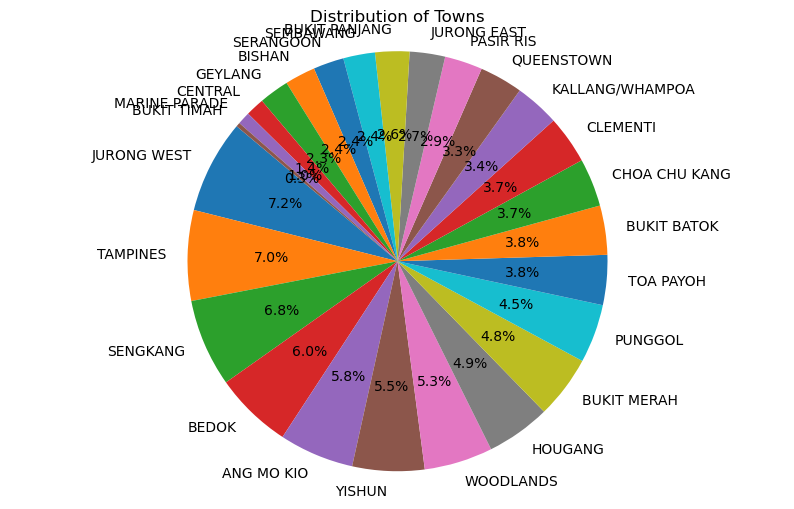

In [46]:
# Count the occurrences of each unique town
town_counts = reduced_combined['town'].value_counts()

# Create the pie chart
plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.pie(town_counts, labels=town_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Distribution of Towns')
plt.show()


In [47]:
### ADD COLUMN for rental price/sqm
reduced_combined = reduced_combined.copy() # Create a copy of the DataFrame slice to avoid the SettingWithCopyWarning
reduced_combined['price_sqm'] = (reduced_combined['monthly_rent'] / reduced_combined['avg_floor_area_sqm']).round(2)

reduced_combined

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,postal,property_age,avg_floor_area_sqm,price_sqm
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4 ROOM,2000,4-ROOM,Northeast,1.372313,103.837601,560105,45.0,92.0,21.74
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,560107,45.0,78.2,22.38
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.370966,103.838202,560108,45.0,74.5,23.49
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2230,5-ROOM,Northeast,1.370851,103.837298,560111,45.0,117.0,19.06
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2450,5-ROOM,Northeast,1.370851,103.837298,560111,45.0,117.0,20.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109314,2023-12,QUEENSTOWN,59,STRATHMORE AVE,4 ROOM,4100,4-ROOM,Central,1.293190,103.811253,142059,23.0,89.3,45.91
109315,2023-12,WOODLANDS,681D,WOODLANDS DR 62,4 ROOM,3300,4-ROOM,North,1.440000,103.803592,734681,23.0,103.0,32.04
109316,2023-12,CHOA CHU KANG,354,CHOA CHU KANG CTRL,4 ROOM,2950,4-ROOM,West,1.382645,103.743561,680354,30.0,106.2,27.78
109317,2023-12,YISHUN,717,YISHUN ST 71,4 ROOM,3200,4-ROOM,North,1.425752,103.828104,760717,36.0,86.5,36.99


In [48]:
#Confirm no Missing data in reduced_combined
reduced_combined.columns.isna()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

Data seems alright, proceed to export for predictive modeling

In [49]:
#reduced_combined.to_csv('rentals_dataset_part1.csv')

In [50]:
rentals_dataset = reduced_combined

### DISTANCE CALULATION
From computed geocodes

In [51]:
from math import sin, cos, sqrt, atan2, radians

def earth_distance(x, y):

  # Approximate radius of earth in km
  R = 6373.0

  lat1, lng1 = radians(x[0]), radians(x[1])
  lat2, lng2 = radians(y[0]), radians(y[1])

  dlon = lng2 - lng1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  return R * c

def euclidean_distance(x, y):
  dx = x[0] - y[0]
  dy = x[1] - y[1]

  return sqrt(dx**2 + dy**2)

jurong_east = [1.333207, 103.742308]
near_amk = [1.365445, 103.842715]
print("Euclidean distance: ", euclidean_distance(jurong_east, near_amk))
print("Realistic distance: ", earth_distance(jurong_east, near_amk))

Euclidean distance:  0.10545546118149039
Realistic distance:  11.726844638513933


### Merging with MRT locations

In [52]:
mrt_locations = pd.read_csv("mrt_data.csv")
mrt_locations.drop(columns=['type'], inplace=True)
mrt_locations

,station_name,lat,lng
0,Jurong East,1.333207,103.742308
1,Bukit Batok,1.349069,103.749596
2,Bukit Gombak,1.359043,103.751863
3,Choa Chu Kang,1.385417,103.744316
4,Yew Tee,1.397383,103.747523
...,...,...,...
115,Bedok Reservoir,1.336595,103.933070
116,Tampines West,1.345583,103.938244
117,Tampines East,1.356310,103.955471
118,Upper Changi,1.342218,103.961505


In [53]:
# Fit the KNeighborsClassifier
X = mrt_locations[['lat', 'lng']]
y = mrt_locations['station_name']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X, y_encoded)

# Predict the nearest MRT station
rentals_dataset['nearest_mrt'] = le.inverse_transform(knn.predict(rentals_dataset[['lat', 'lng']]))


In [54]:

# Add column for train_dist
rentals_dataset['mrt_dist'] = rentals_dataset.apply(
    lambda row: earth_distance(mrt_locations.loc[mrt_locations['station_name'] == row['nearest_mrt'], ['lat', 'lng']].values[0], 
                               (row['lat'], row['lng'])), axis=1)


### Merging with Busstop Locations

In [55]:
'''
busstop_locations = pd.read_csv("busstops.csv", index_col=0) 
busstop_locations.rename(columns={'Latitude':'lat', 'Longitude':'lng'},inplace=True)
busstop_locations
'''

'\nbusstop_locations = pd.read_csv("busstops.csv", index_col=0) \nbusstop_locations.rename(columns={\'Latitude\':\'lat\', \'Longitude\':\'lng\'},inplace=True)\nbusstop_locations\n'

In [56]:
'''
# Fit the KNeighborsClassifier
X = busstop_locations[['lat', 'lng']]
y = busstop_locations['Description']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X, y_encoded)

# Predict the nearest busstop
rentals_dataset['nearest_busstop'] = le.inverse_transform(knn.predict(rentals_dataset[['lat', 'lng']]))

# Add column for busstop_dist
rentals_dataset['busstop_dist'] = rentals_dataset.apply(
    lambda row: earth_distance(busstop_locations.loc[busstop_locations['Description'] == row['nearest_busstop'], ['lat', 'lng']].values[0], 
                               (row['lat'], row['lng'])), axis=1)

'''




"\n# Fit the KNeighborsClassifier\nX = busstop_locations[['lat', 'lng']]\ny = busstop_locations['Description']\nle = LabelEncoder()\ny_encoded = le.fit_transform(y)\n\nknn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')\nknn.fit(X, y_encoded)\n\n# Predict the nearest busstop\nrentals_dataset['nearest_busstop'] = le.inverse_transform(knn.predict(rentals_dataset[['lat', 'lng']]))\n\n# Add column for busstop_dist\nrentals_dataset['busstop_dist'] = rentals_dataset.apply(\n    lambda row: earth_distance(busstop_locations.loc[busstop_locations['Description'] == row['nearest_busstop'], ['lat', 'lng']].values[0], \n                               (row['lat'], row['lng'])), axis=1)\n\n"

### Merging with SHOPPING Locations
identify nearest shopping mall distance to the rental flats

In [57]:
shopping_locations = pd.read_csv('shopping_mall_coordinates.csv', index_col = 0)

In [58]:
# Fit the KNeighborsClassifier
X = shopping_locations[['lat', 'lng']]
y = shopping_locations['Mall Name']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X, y_encoded)

# Predict the nearest shopping malls
rentals_dataset['nearest_shopping'] = le.inverse_transform(knn.predict(rentals_dataset[['lat', 'lng']]))

# Add column for shopping_dist
rentals_dataset['shopping_dist'] = rentals_dataset.apply(
    lambda row: earth_distance(shopping_locations.loc[shopping_locations['Mall Name'] == row['nearest_shopping'], ['lat', 'lng']].values[0], 
                               (row['lat'], row['lng'])), axis=1)


### Merging with International/Private school locations
school_locations(moeschools and nonMOEschools)

In [59]:
intschool_locations = pd.read_csv('intschool_locations.csv', index_col = 0)
intschool_locations = intschool_locations.drop(columns=['building'])
intschool_locations = intschool_locations.rename(columns={'searchval':'building'})
intschool_locations

,lat,lng,building,postal
0,1.306379,103.905164,5 STEPS ACADEMY,428833
1,1.301061,103.781310,ACS INDEPENDENT BOARDING SCHOOL,139656
2,1.307747,103.798542,ACS INTERNATIONAL,278475
3,1.319923,103.834958,ACS OLDHAM HALL BOARDING SCHOOL,309937
4,1.301852,103.780141,ANGLO-CHINESE SCHOOL (INDEPENDENT),139650
...,...,...,...,...
111,1.291595,103.857049,PSB ACADEMY,39594
112,1.300206,103.837317,RAFFLES COLLEGE OF HIGHER EDUCATION,238164
113,1.274527,103.845777,SISH INSTITUTE,79904
114,1.275215,103.801330,SINGAPORE RAFFLES MUSIC COLLEGE,119962


##### Add only private and international schools location data to identify nearest schools distance to the rental flats

In [60]:
# Fit the KNeighborsClassifier
X = intschool_locations[['lat', 'lng']]
y = intschool_locations['building']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X, y_encoded)

# Predict the nearest shopping malls
rentals_dataset['nearest_intschool'] = le.inverse_transform(knn.predict(rentals_dataset[['lat', 'lng']]))

In [61]:
# Add column for school_dist
rentals_dataset['intschool_dist'] = rentals_dataset.apply(
    lambda row: earth_distance(intschool_locations.loc[intschool_locations['building'] == row['nearest_intschool'], ['lat', 'lng']].values[0], 
                               (row['lat'], row['lng'])), axis=1)


### Merging with HAWKERS/MARKETS Locations

In [62]:
hawkers = pd.read_csv('hawkers_dataset.csv')

In [63]:
# Fit the KNeighborsClassifier
X = hawkers[['lat', 'lng']]
y = hawkers['name_of_centre']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X, y_encoded)

# Predict the nearest schools
rentals_dataset['nearest_hawker'] = le.inverse_transform(knn.predict(rentals_dataset[['lat', 'lng']]))


In [64]:

# Add column for hawker_dist
rentals_dataset['hawker_dist'] = rentals_dataset.apply(
    lambda row: earth_distance(hawkers.loc[hawkers['name_of_centre'] == row['nearest_hawker'], ['lat', 'lng']].values[0], 
                               (row['lat'], row['lng'])), axis=1)


#### REVIEW Final Rental Dataset after all the merging

In [65]:
rentals_dataset

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,...,avg_floor_area_sqm,price_sqm,nearest_mrt,mrt_dist,nearest_shopping,shopping_dist,nearest_intschool,intschool_dist,nearest_hawker,hawker_dist
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4 ROOM,2000,4-ROOM,Northeast,1.372313,103.837601,...,92.0,21.74,Yio Chu Kang,1.329716,Broadway Plaza,0.929260,NANYANG POLYTECHNIC,1.529100,Blks 160/162 Ang Mo Kio Ave 4,0.244028
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.371384,103.837381,...,78.2,22.38,Ang Mo Kio,1.365741,Broadway Plaza,0.954735,NANYANG POLYTECHNIC,1.607337,Blks 160/162 Ang Mo Kio Ave 4,0.344891
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3 ROOM,1750,3-ROOM,Northeast,1.370966,103.838202,...,74.5,23.49,Ang Mo Kio,1.270434,Broadway Plaza,0.868254,NANYANG POLYTECHNIC,1.562581,Blks 160/162 Ang Mo Kio Ave 4,0.357068
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2230,5-ROOM,Northeast,1.370851,103.837298,...,117.0,19.06,Ang Mo Kio,1.369690,Broadway Plaza,0.969552,NANYANG POLYTECHNIC,1.649779,Blks 160/162 Ang Mo Kio Ave 4,0.401847
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5 ROOM,2450,5-ROOM,Northeast,1.370851,103.837298,...,117.0,20.94,Ang Mo Kio,1.369690,Broadway Plaza,0.969552,NANYANG POLYTECHNIC,1.649779,Blks 160/162 Ang Mo Kio Ave 4,0.401847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109314,2023-12,QUEENSTOWN,59,STRATHMORE AVE,4 ROOM,4100,4-ROOM,Central,1.293190,103.811253,...,89.3,45.91,Queenstown,0.623560,Anchorpoint,0.786134,ASTOR INTERNATIONAL SCHOOL,0.591196,ABC Brickworks Market & Food Centre,0.782664
109315,2023-12,WOODLANDS,681D,WOODLANDS DR 62,4 ROOM,3300,4-ROOM,North,1.440000,103.803592,...,103.0,32.04,Admiralty,0.296640,Admiralty Place,0.232765,REPUBLIC POLYTECHNIC,2.184021,Chong Pang Market & Food Centre,2.932362
109316,2023-12,CHOA CHU KANG,354,CHOA CHU KANG CTRL,4 ROOM,2950,4-ROOM,West,1.382645,103.743561,...,106.2,27.78,Choa Chu Kang,0.319505,Lot One,0.327919,HERITAGE ACADEMY @ BUKIT GOMBAK,2.742494,253 Choa Chu Kang Market & Food Centre,0.661868
109317,2023-12,YISHUN,717,YISHUN ST 71,4 ROOM,3200,4-ROOM,North,1.425752,103.828104,...,86.5,36.99,Yishun,0.885971,Northpoint City,0.964711,HERITAGE ACADEMY,1.233403,Chong Pang Market & Food Centre,0.635330


In [66]:
rentals_dataset.columns

Index(['date', 'town', 'block', 'street_name', 'flat_type', 'monthly_rent',
       'flat_type_group', 'region', 'lat', 'lng', 'postal', 'property_age',
       'avg_floor_area_sqm', 'price_sqm', 'nearest_mrt', 'mrt_dist',
       'nearest_shopping', 'shopping_dist', 'nearest_intschool',
       'intschool_dist', 'nearest_hawker', 'hawker_dist'],
      dtype='object')

In [67]:
rentals_dataset.columns.isna()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [68]:
rentals_dataset.to_csv('rentals_dataset.csv')

### CHECK OUTLIERS

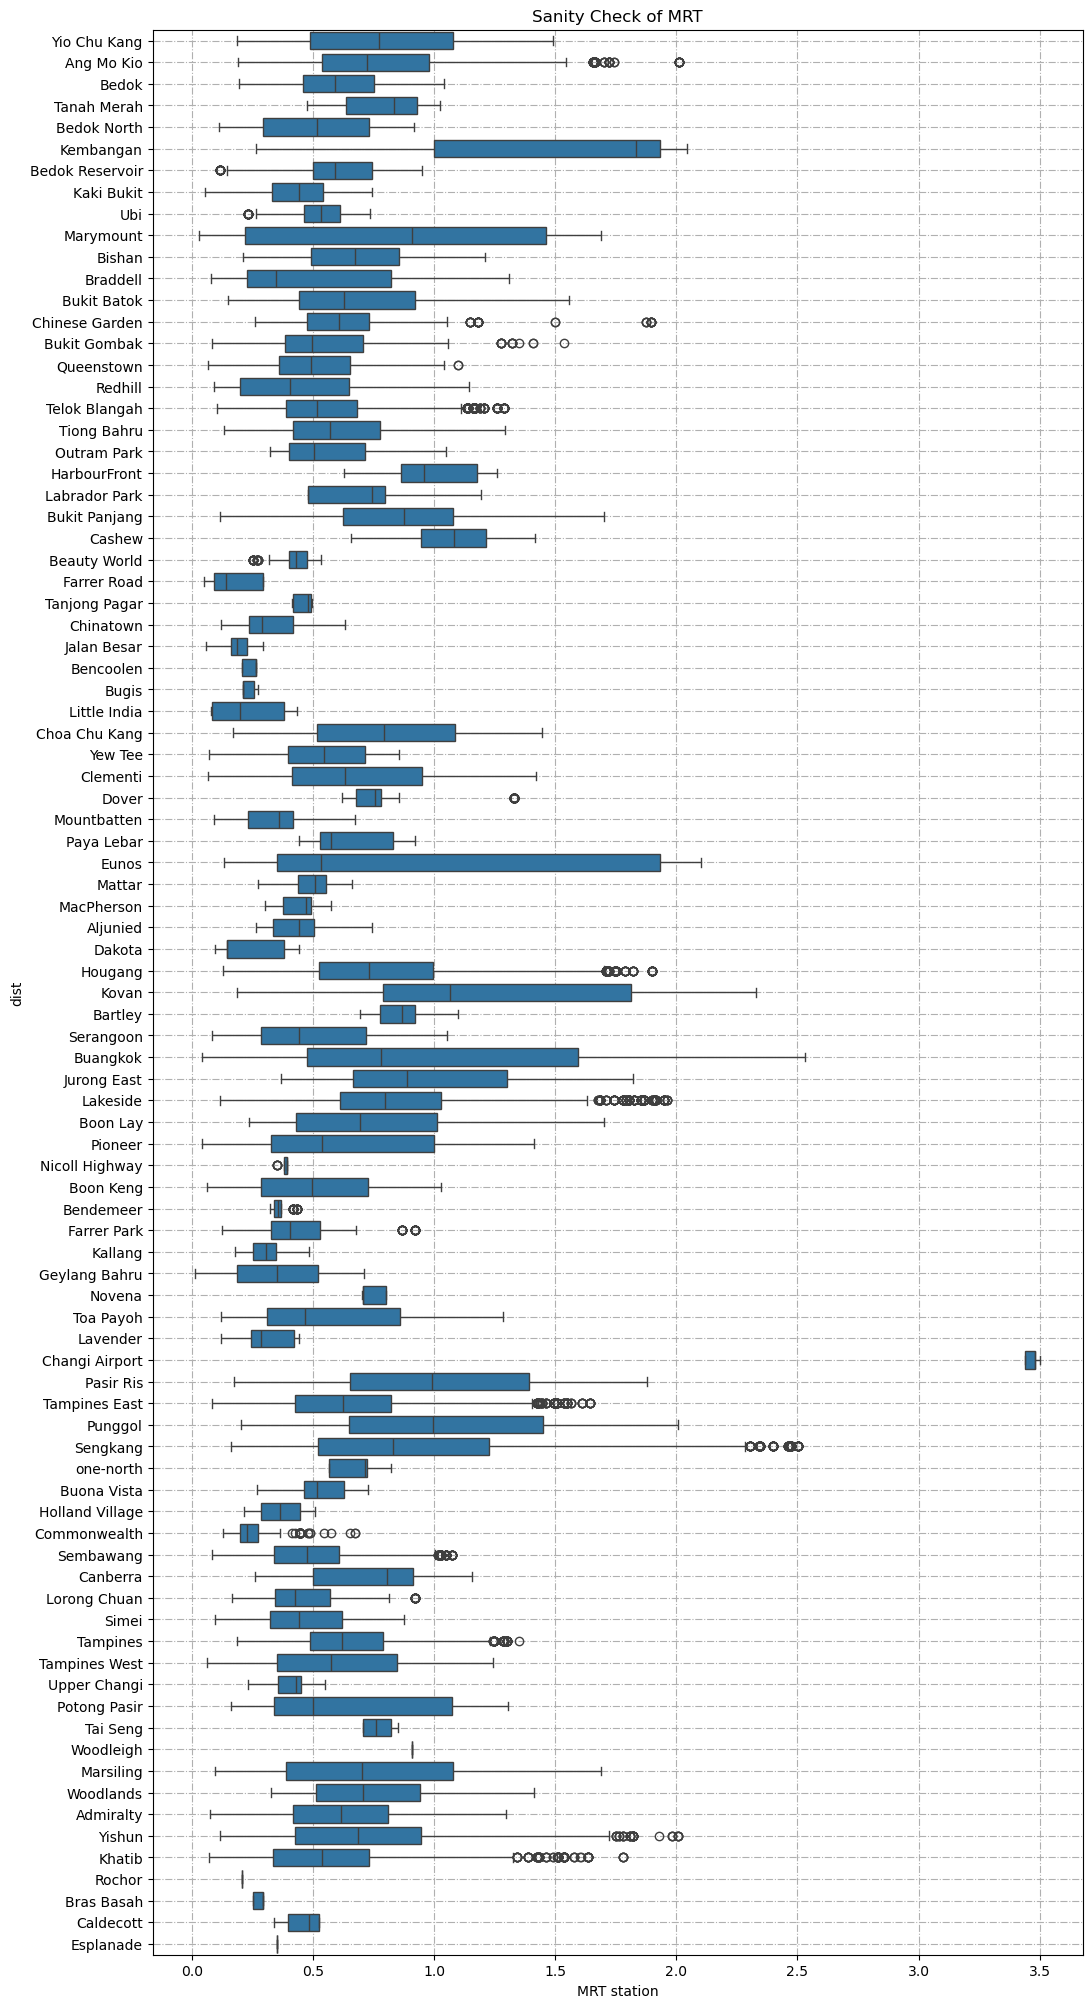

In [69]:

df = rentals_dataset

plt.figure(figsize=(12, 25))  
sns.boxplot(x='mrt_dist', y='nearest_mrt', data=df)
#plt.xticks(rotation=90)
plt.xlabel('MRT station')
plt.ylabel('dist')
plt.title('Sanity Check of MRT')
plt.grid(linestyle='-.', axis = 'both')

plt.savefig('./images/outlier_rental_MRT.png') 
plt.show()


In [70]:
df[(df['nearest_mrt']=='Sembawang') & (df['mrt_dist'] > 1.4)]

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,...,avg_floor_area_sqm,price_sqm,nearest_mrt,mrt_dist,nearest_shopping,shopping_dist,nearest_intschool,intschool_dist,nearest_hawker,hawker_dist


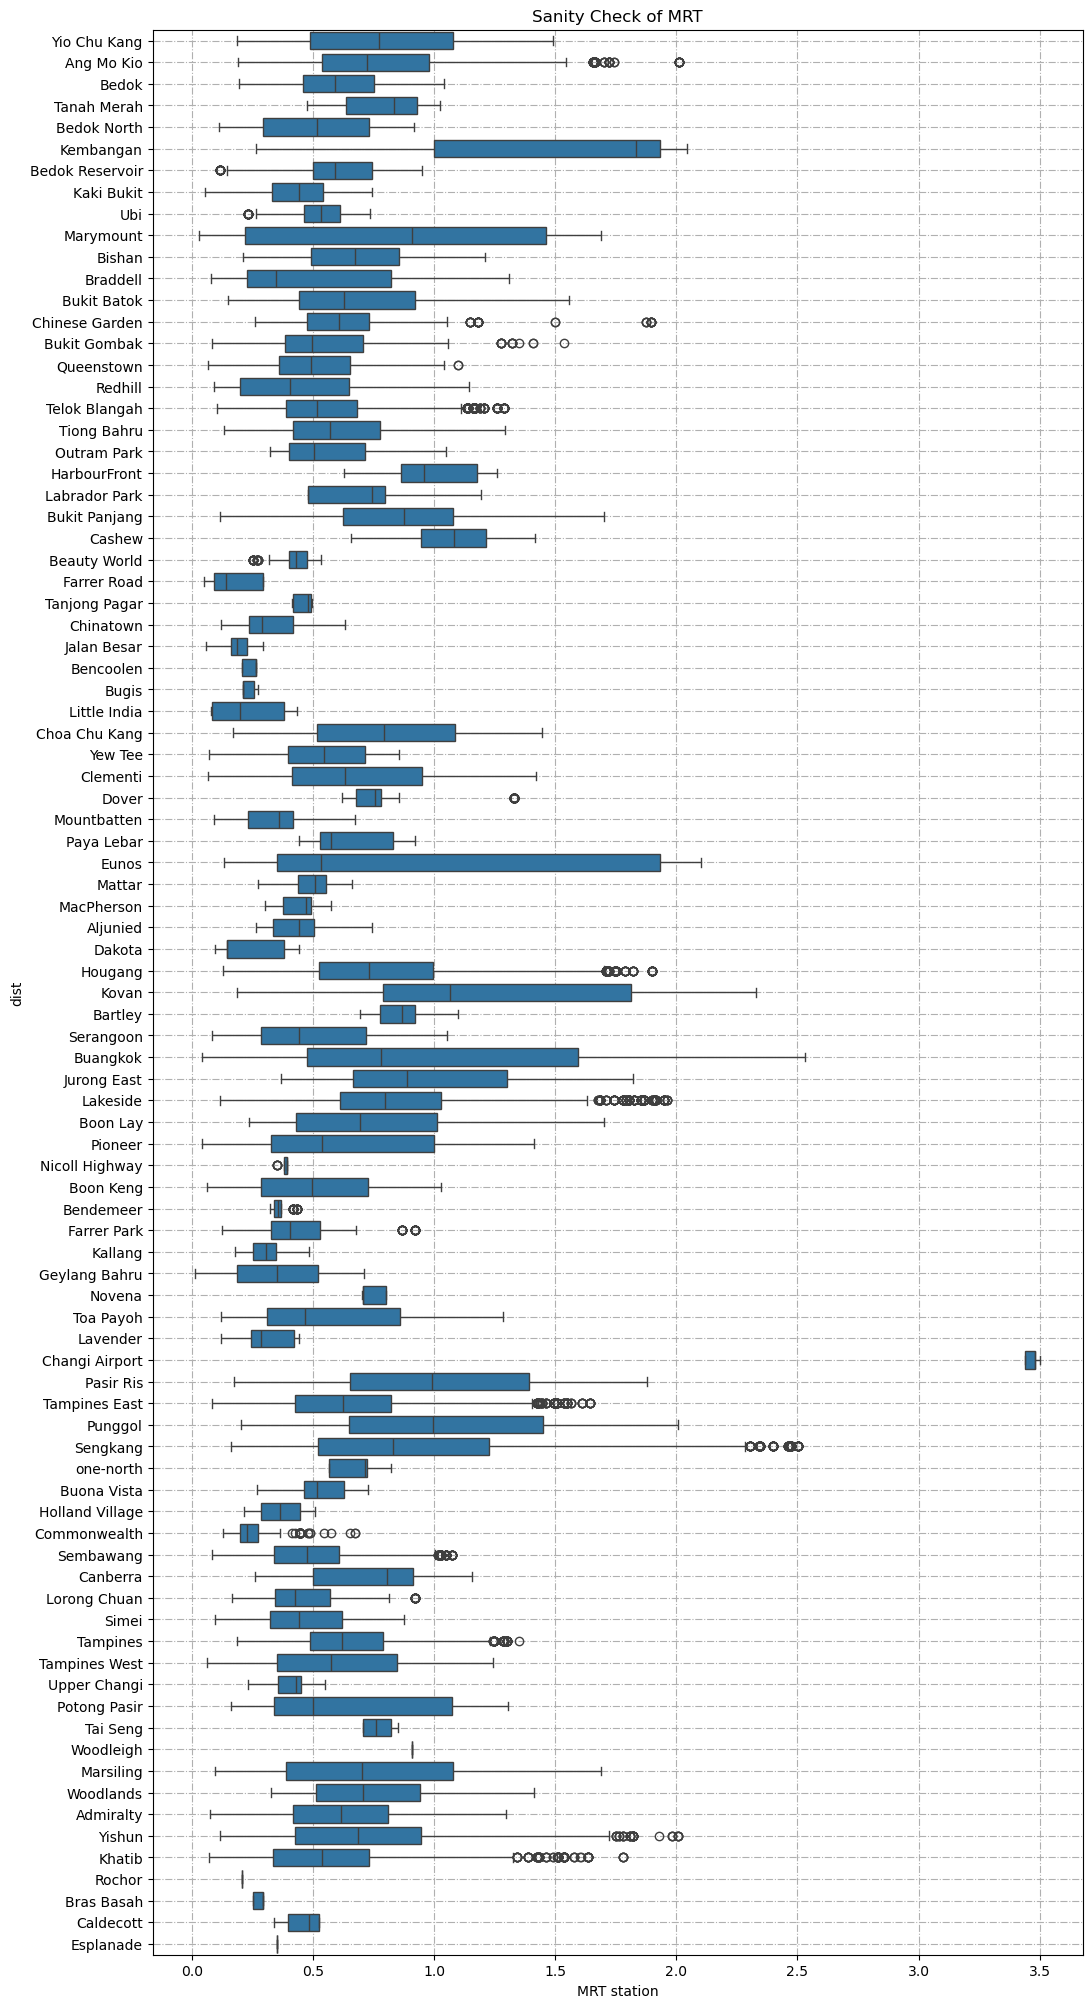

In [71]:

df = rentals_dataset

plt.figure(figsize=(12, 25))  # Optional: Adjusts the size of the figure
sns.boxplot(x='mrt_dist', y='nearest_mrt', data=df)
#plt.xticks(rotation=90)
plt.xlabel('MRT station')
plt.ylabel('dist')
plt.title('Sanity Check of MRT')
plt.grid(linestyle='-.', axis = 'both')

plt.savefig('./images/outlier_rental_mrt_addedcanberra.png') 
plt.show()


In [72]:
## Fixed for this group of hdb, initially nearest mrt as sembawang
#df[df['postal']=='754120']

In [73]:
df[(df['nearest_mrt']=='Yishun') & (df['mrt_dist'] > 2)]

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,...,avg_floor_area_sqm,price_sqm,nearest_mrt,mrt_dist,nearest_shopping,shopping_dist,nearest_intschool,intschool_dist,nearest_hawker,hawker_dist
12954,2021-04,YISHUN,469A,YISHUN ST 43,2 ROOM,1000,2-ROOM,North,1.424694,103.852386,...,47.0,21.28,Yishun,2.006051,Wisteria Mall,1.439054,XCL AMERICAN ACADEMY,0.152828,Chong Pang Market & Food Centre,2.756135
23157,2021-07,YISHUN,469A,YISHUN ST 43,2 ROOM,1700,2-ROOM,North,1.424694,103.852386,...,47.0,36.17,Yishun,2.006051,Wisteria Mall,1.439054,XCL AMERICAN ACADEMY,0.152828,Chong Pang Market & Food Centre,2.756135
106195,2023-11,YISHUN,469A,YISHUN ST 43,4 ROOM,3500,4-ROOM,North,1.424694,103.852386,...,93.0,37.63,Yishun,2.006051,Wisteria Mall,1.439054,XCL AMERICAN ACADEMY,0.152828,Chong Pang Market & Food Centre,2.756135
108878,2023-12,YISHUN,469A,YISHUN ST 43,2 ROOM,2400,2-ROOM,North,1.424694,103.852386,...,47.0,51.06,Yishun,2.006051,Wisteria Mall,1.439054,XCL AMERICAN ACADEMY,0.152828,Chong Pang Market & Food Centre,2.756135


In [74]:
print('to semb station:',earth_distance([1.446768,103.832298],[1.449133,103.82006]))
print('to previous canberra station:', earth_distance([1.446768,103.832298],[1.449026685,103.8201395]))
print('to canberra station:', earth_distance([1.446768,103.832298],[1.4433,103.8296]))

to semb station: 1.3859890647223096
to previous canberra station: 1.3751012616585183
to canberra station: 0.4886725322991821


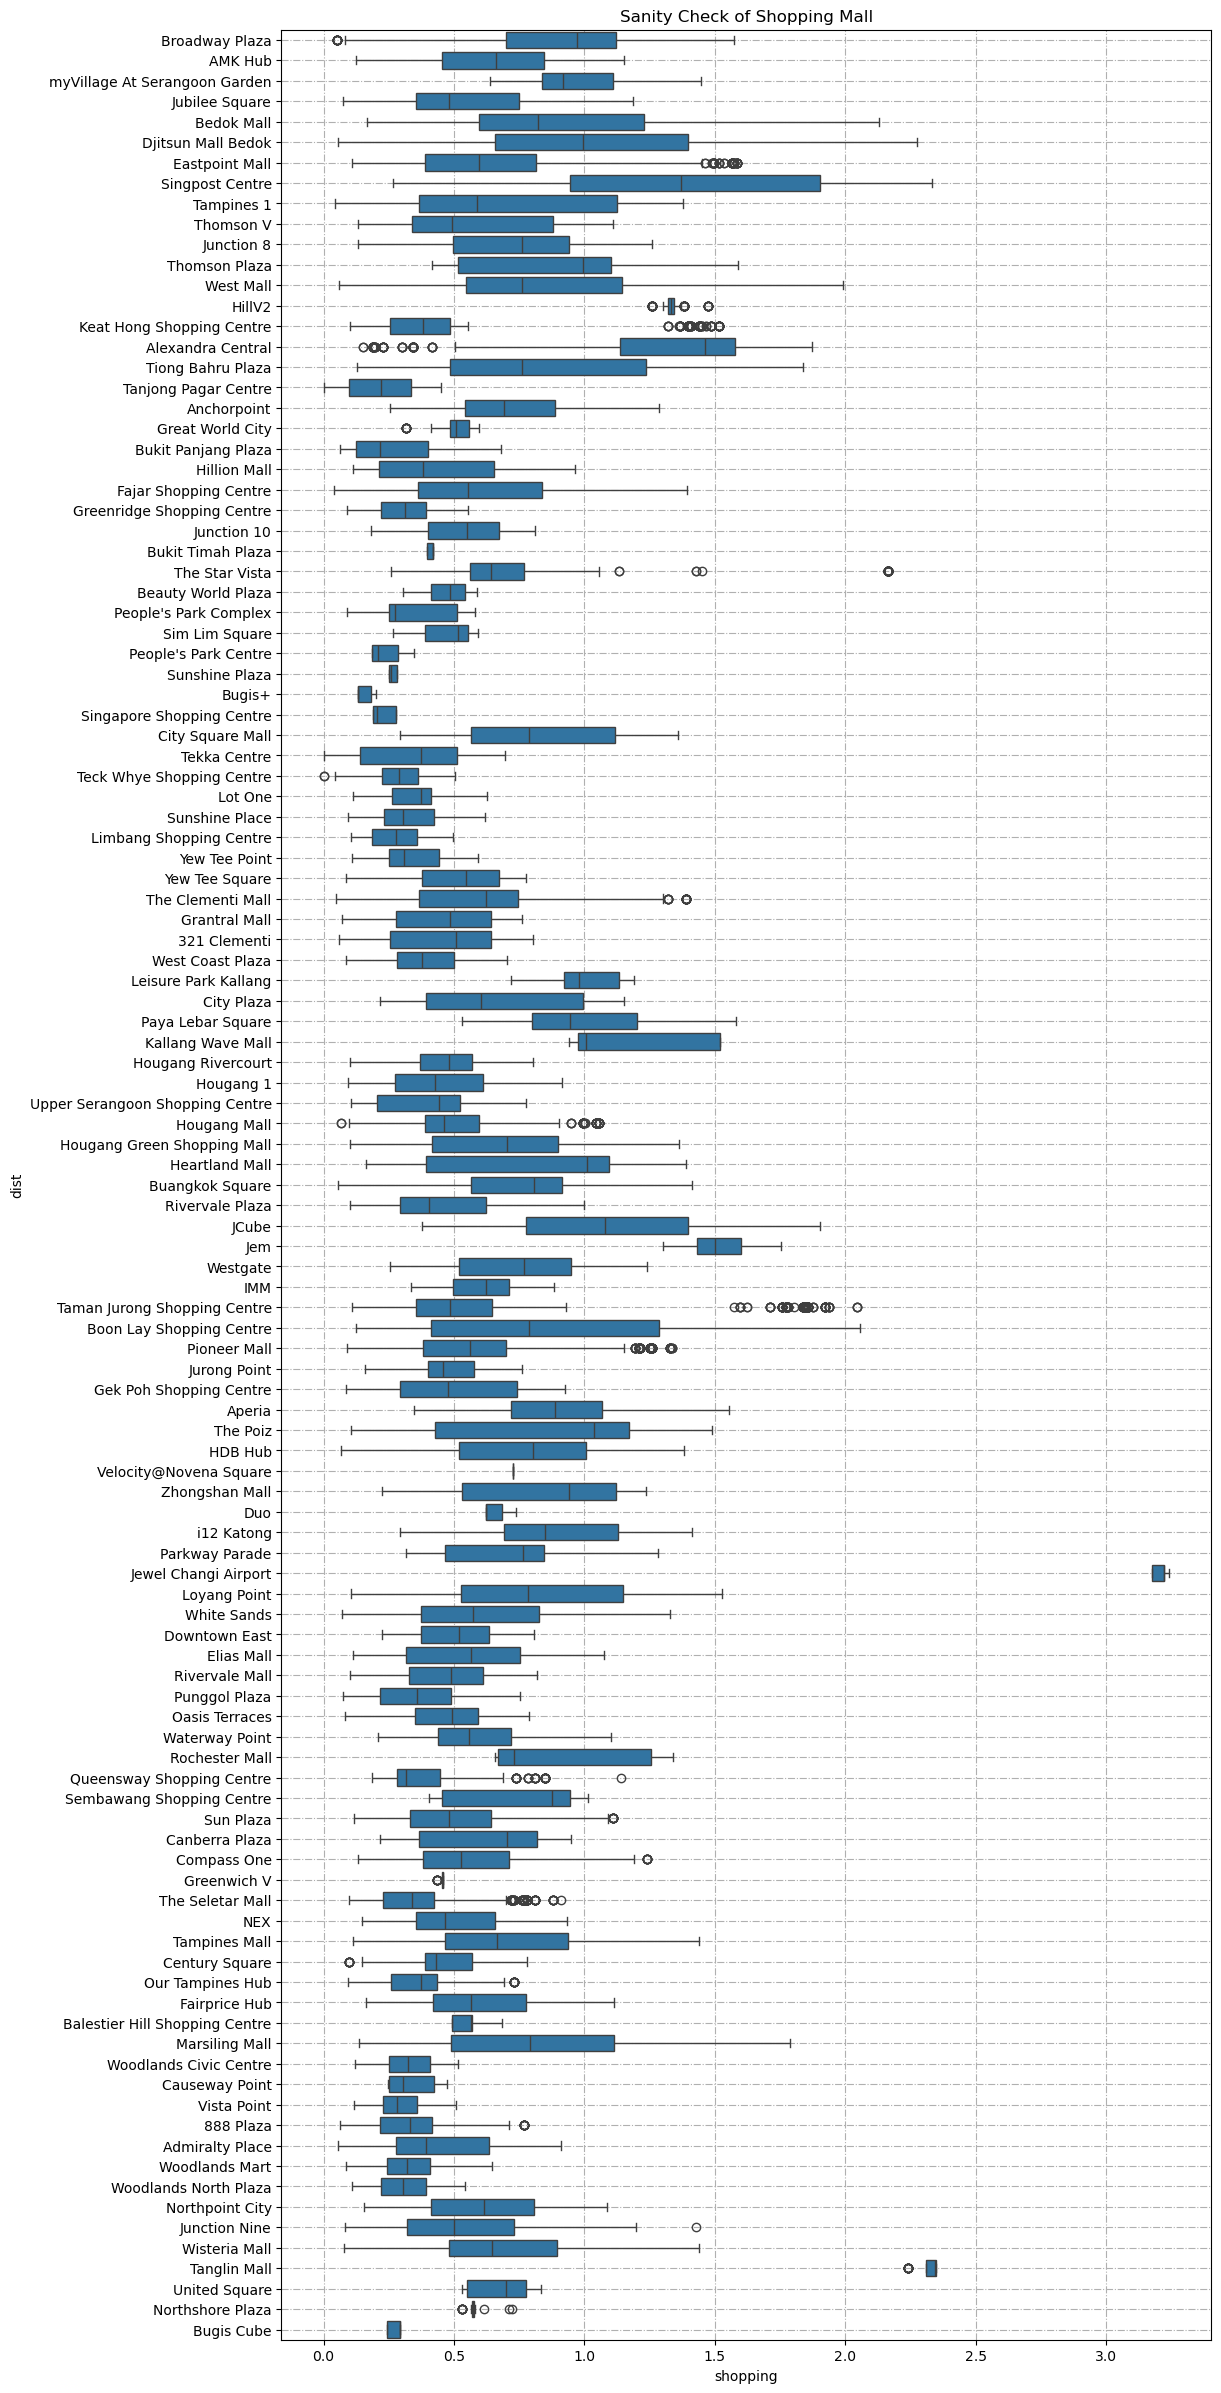

In [75]:

df = rentals_dataset

plt.figure(figsize=(12, 30))  # Optional: Adjusts the size of the figure
sns.boxplot(x='shopping_dist', y='nearest_shopping', data=df)
#plt.xticks(rotation=90)
plt.xlabel('shopping')
plt.ylabel('dist')
plt.title('Sanity Check of Shopping Mall')
plt.grid(linestyle='-.', axis = 'both')

plt.savefig('./images/outlier_rental_shoppingmalls.png') 
plt.show()


In [76]:
# df[(df['nearest_shopping'] == 'Keat Hong Shopping Centre') & (df['shopping_dist'] > 1)]
# df[(df['nearest_shopping'] == 'The Star Vista') & (df['shopping_dist'] > 2)] # 8	EMPRESS RD

In [77]:
# df[(df['nearest_shopping'] == 'Taman Jurong Shopping Centre') & (df['shopping_dist'] > 2)] #340	JURONG EAST AVE 1
#print('taman', earth_distance([1.350127,103.730688],[1.346348197,103.7124293]))
#print('toboonlayshopping', earth_distance([1.350127,103.730688],[1.334844875,103.720462]))

/var/folders/jx/wm1d645968d9y3dt9w8l2_1m0000gn/T/ipykernel_18694/3079709832.py:11: UserWarning: Glyph 9 (	) missing from current font.
  plt.savefig('./images/outlier_rental_intschool.png')
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


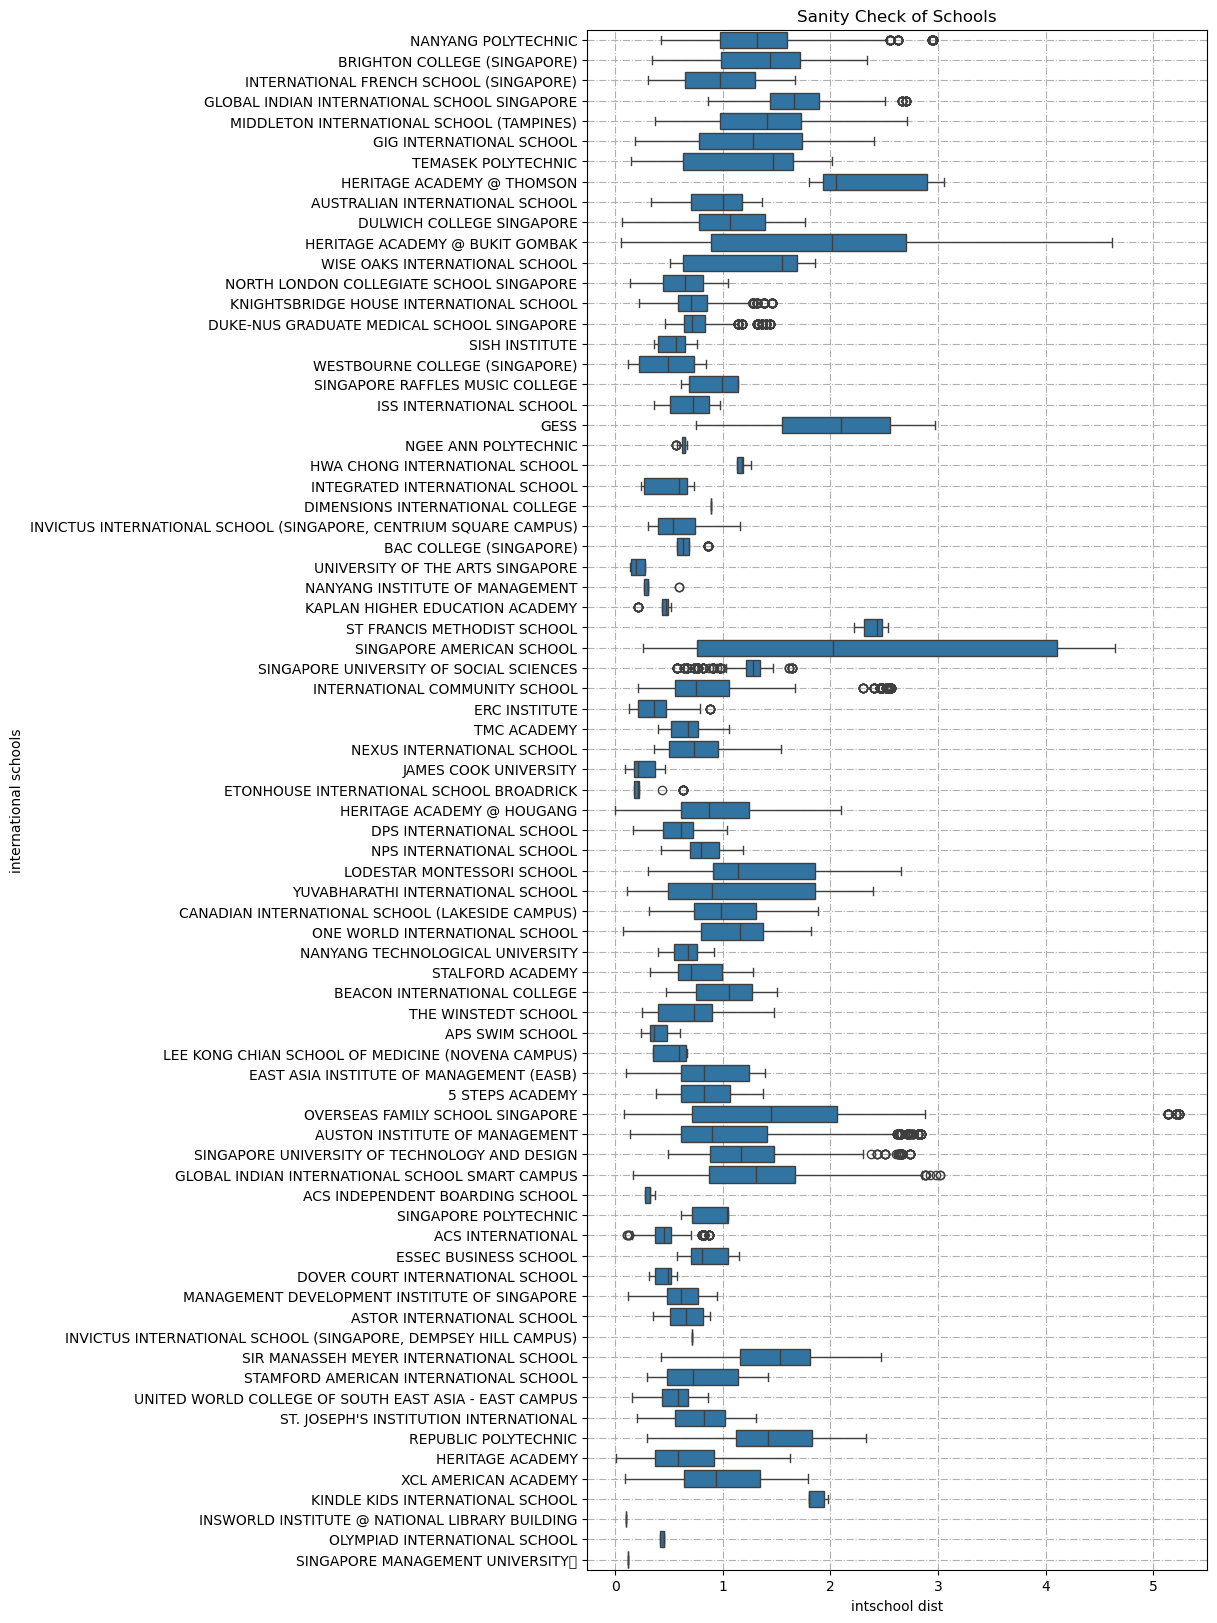

In [78]:

df = rentals_dataset

plt.figure(figsize=(8, 20)) 
sns.boxplot(x='intschool_dist', y='nearest_intschool', data=df)
#plt.xticks(rotation=90)
plt.xlabel('intschool dist')
plt.ylabel('international schools')
plt.title('Sanity Check of Schools')
plt.grid(linestyle='-.', axis = 'both')

plt.savefig('./images/outlier_rental_intschool.png') 
plt.show()


In [79]:
rentals_dataset[(rentals_dataset['nearest_intschool']=='OVERSEAS FAMILY SCHOOL SINGAPORE') & (rentals_dataset['intschool_dist']>4)]

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,...,avg_floor_area_sqm,price_sqm,nearest_mrt,mrt_dist,nearest_shopping,shopping_dist,nearest_intschool,intschool_dist,nearest_hawker,hawker_dist
1809,2021-01,PASIR RIS,1,CHANGI VILLAGE RD,3 ROOM,1000,3-ROOM,East,1.388547,103.987804,...,70.0,14.29,Changi Airport,3.440571,Jewel Changi Airport,3.177534,OVERSEAS FAMILY SCHOOL SINGAPORE,5.240128,Blks 2 & 3 Changi Village Road,0.127723
1810,2021-01,PASIR RIS,1,CHANGI VILLAGE RD,3 ROOM,1800,3-ROOM,East,1.388547,103.987804,...,70.0,25.71,Changi Airport,3.440571,Jewel Changi Airport,3.177534,OVERSEAS FAMILY SCHOOL SINGAPORE,5.240128,Blks 2 & 3 Changi Village Road,0.127723
8235,2021-03,PASIR RIS,5,CHANGI VILLAGE RD,3 ROOM,1800,3-ROOM,East,1.388853,103.986846,...,72.0,25.00,Changi Airport,3.478653,Jewel Changi Airport,3.221380,OVERSEAS FAMILY SCHOOL SINGAPORE,5.141322,Blks 2 & 3 Changi Village Road,0.164944
8236,2021-03,PASIR RIS,5,CHANGI VILLAGE RD,3 ROOM,2200,3-ROOM,East,1.388853,103.986846,...,72.0,30.56,Changi Airport,3.478653,Jewel Changi Airport,3.221380,OVERSEAS FAMILY SCHOOL SINGAPORE,5.141322,Blks 2 & 3 Changi Village Road,0.164944
11601,2021-04,PASIR RIS,4,CHANGI VILLAGE RD,3 ROOM,1600,3-ROOM,East,1.389096,103.987463,...,70.0,22.86,Changi Airport,3.502739,Jewel Changi Airport,3.241583,OVERSEAS FAMILY SCHOOL SINGAPORE,5.213714,Blks 2 & 3 Changi Village Road,0.093806
11602,2021-04,PASIR RIS,5,CHANGI VILLAGE RD,3 ROOM,2100,3-ROOM,East,1.388853,103.986846,...,72.0,29.17,Changi Airport,3.478653,Jewel Changi Airport,3.221380,OVERSEAS FAMILY SCHOOL SINGAPORE,5.141322,Blks 2 & 3 Changi Village Road,0.164944
18413,2021-06,PASIR RIS,1,CHANGI VILLAGE RD,3 ROOM,1600,3-ROOM,East,1.388547,103.987804,...,70.0,22.86,Changi Airport,3.440571,Jewel Changi Airport,3.177534,OVERSEAS FAMILY SCHOOL SINGAPORE,5.240128,Blks 2 & 3 Changi Village Road,0.127723
18414,2021-06,PASIR RIS,5,CHANGI VILLAGE RD,3 ROOM,2000,3-ROOM,East,1.388853,103.986846,...,72.0,27.78,Changi Airport,3.478653,Jewel Changi Airport,3.221380,OVERSEAS FAMILY SCHOOL SINGAPORE,5.141322,Blks 2 & 3 Changi Village Road,0.164944
21772,2021-07,PASIR RIS,5,CHANGI VILLAGE RD,3 ROOM,2000,3-ROOM,East,1.388853,103.986846,...,72.0,27.78,Changi Airport,3.478653,Jewel Changi Airport,3.221380,OVERSEAS FAMILY SCHOOL SINGAPORE,5.141322,Blks 2 & 3 Changi Village Road,0.164944
21773,2021-07,PASIR RIS,5,CHANGI VILLAGE RD,3 ROOM,1900,3-ROOM,East,1.388853,103.986846,...,72.0,26.39,Changi Airport,3.478653,Jewel Changi Airport,3.221380,OVERSEAS FAMILY SCHOOL SINGAPORE,5.141322,Blks 2 & 3 Changi Village Road,0.164944


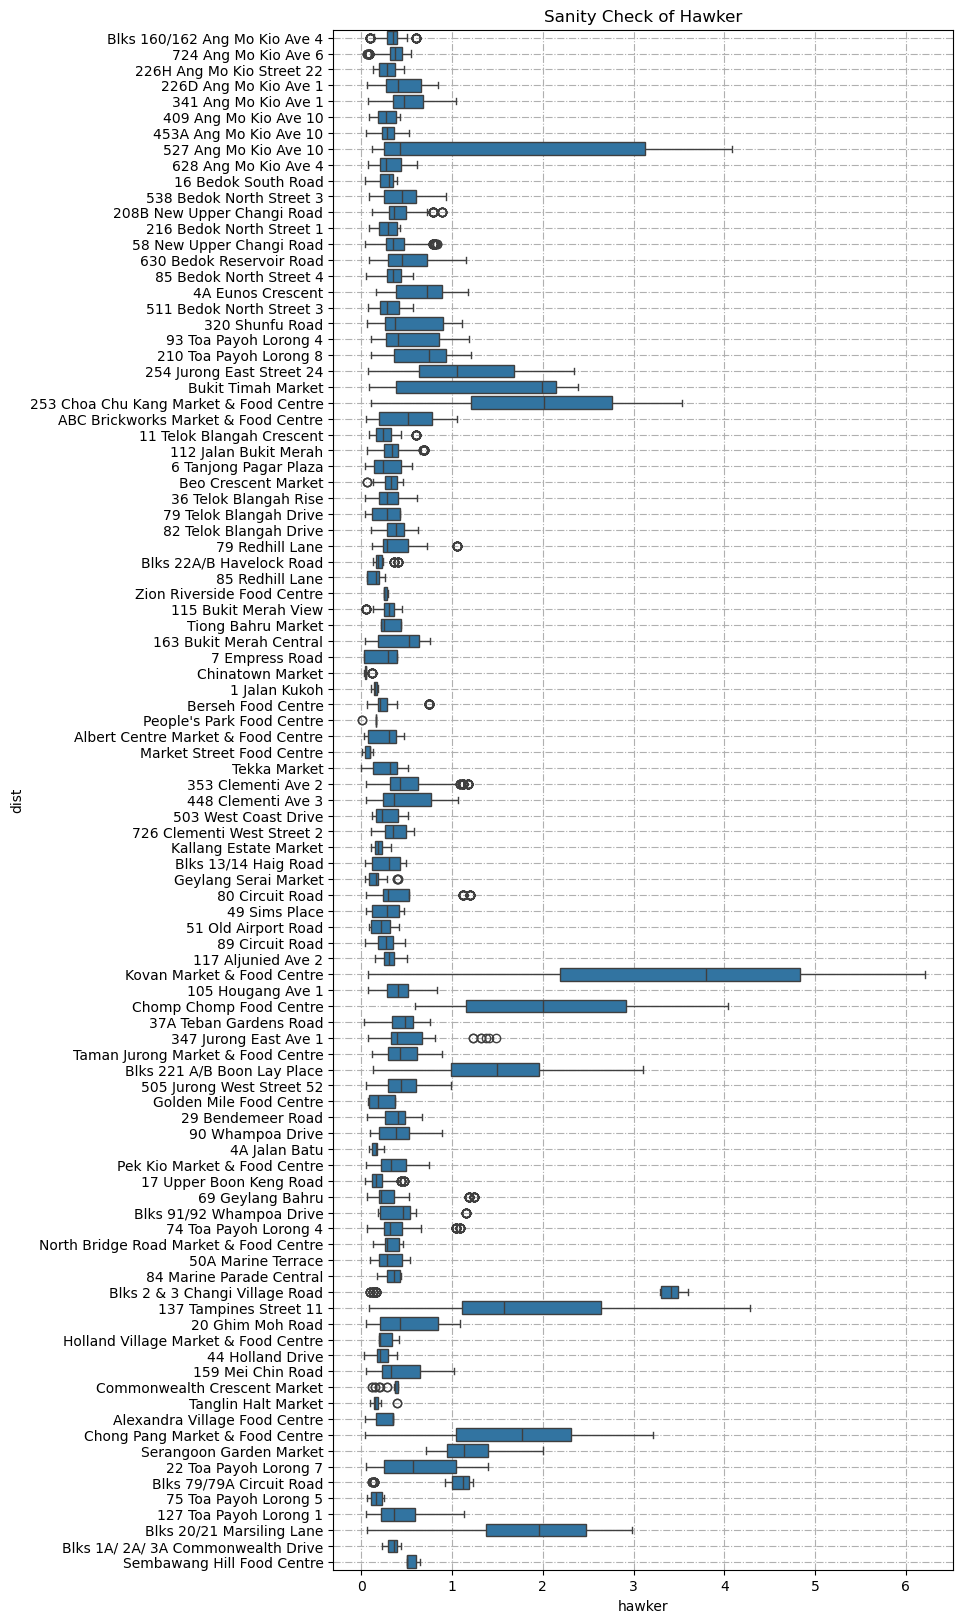

In [80]:

df = rentals_dataset

plt.figure(figsize=(8, 20)) 
sns.boxplot(x='hawker_dist', y='nearest_hawker', data=df)
#plt.xticks(rotation=90)
plt.xlabel('hawker')
plt.ylabel('dist')
plt.title('Sanity Check of Hawker')
plt.grid(linestyle='-.', axis = 'both')

plt.savefig('./images/outlier_rental_hawker.png') 
plt.show()


In [81]:
rentals_dataset[rentals_dataset['nearest_hawker']=='Blks 20/21 Marsiling Lane']

,date,town,block,street_name,flat_type,monthly_rent,flat_type_group,region,lat,lng,...,avg_floor_area_sqm,price_sqm,nearest_mrt,mrt_dist,nearest_shopping,shopping_dist,nearest_intschool,intschool_dist,nearest_hawker,hawker_dist
2895,2021-01,WOODLANDS,2,MARSILING DR,3 ROOM,1200,3-ROOM,North,1.439938,103.776695,...,66.7,17.99,Marsiling,0.866102,Marsiling Mall,0.794718,REPUBLIC POLYTECHNIC,0.949459,Blks 20/21 Marsiling Lane,0.436837
2896,2021-01,WOODLANDS,2,MARSILING DR,3 ROOM,2100,3-ROOM,North,1.439938,103.776695,...,66.7,31.48,Marsiling,0.866102,Marsiling Mall,0.794718,REPUBLIC POLYTECHNIC,0.949459,Blks 20/21 Marsiling Lane,0.436837
2897,2021-01,WOODLANDS,6,MARSILING DR,3 ROOM,2200,3-ROOM,North,1.442073,103.776354,...,73.0,30.14,Marsiling,1.084078,Marsiling Mall,1.026668,REPUBLIC POLYTECHNIC,0.905818,Blks 20/21 Marsiling Lane,0.217564
2898,2021-01,WOODLANDS,17,MARSILING LANE,3 ROOM,1700,3-ROOM,North,1.442678,103.777725,...,70.0,24.29,Woodlands,1.154570,Marsiling Mall,1.044024,REPUBLIC POLYTECHNIC,0.743462,Blks 20/21 Marsiling Lane,0.140454
2899,2021-01,WOODLANDS,18,MARSILING LANE,3 ROOM,1200,3-ROOM,North,1.443417,103.777861,...,68.0,17.65,Woodlands,1.189437,Marsiling Mall,1.121013,REPUBLIC POLYTECHNIC,0.719201,Blks 20/21 Marsiling Lane,0.085813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109208,2023-12,WOODLANDS,716,WOODLANDS DR 70,5 ROOM,2350,5-ROOM,North,1.441508,103.799779,...,120.5,19.50,Admiralty,0.169175,Admiralty Place,0.230394,REPUBLIC POLYTECHNIC,1.737568,Blks 20/21 Marsiling Lane,2.522754
109221,2023-12,WOODLANDS,23,MARSILING DR,3 ROOM,2800,3-ROOM,North,1.441540,103.773300,...,74.5,37.58,Marsiling,1.001176,Marsiling Mall,1.151863,REPUBLIC POLYTECHNIC,1.250373,Blks 20/21 Marsiling Lane,0.504045
109259,2023-12,WOODLANDS,166,WOODLANDS ST 13,4 ROOM,2500,4-ROOM,North,1.433318,103.775492,...,92.0,27.17,Marsiling,0.170312,Marsiling Mall,0.488822,SINGAPORE AMERICAN SCHOOL,0.777586,Blks 20/21 Marsiling Lane,1.184975
109262,2023-12,WOODLANDS,894A,WOODLANDS DR 50,5 ROOM,3800,5-ROOM,North,1.436011,103.790367,...,119.5,31.80,Woodlands,0.453525,Woodlands Civic Centre,0.406281,REPUBLIC POLYTECHNIC,1.095147,Blks 20/21 Marsiling Lane,1.702004
